# Setting up Imports and connecting to AWS EC2 Instance

In [ ]:
# necessary installations for the first time 
# !pip install tensorflow 
# !pip3 install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu113
# !pip install opencv-python


# !pip install timm
# !pip install transformers
# !pip install albumentations
# !pip install tensorflow
# !pip install opencv-python-headless==4.5.2.52

In [ ]:
# Download and unzip dataset from scratch 
# ! pip install kaggle
# ! mkdir ~/.kaggle
# !cp kaggle.json ~/.kaggle/kaggle.json
# !chmod 600 ~/.kaggle/kaggle.json
# !kaggle competitions download -c h-and-m-personalized-fashion-recommendations
# !unzip -q h-and-m-personalized-fashion-recommendations.zip -d .

In [ ]:
import torch
import pandas as pd 
import numpy as np 
import os
import cv2
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
from torch import nn
import torch.nn.functional as F
import timm
from transformers import DistilBertModel, DistilBertConfig, DistilBertTokenizer
import albumentations as alb
from tqdm.autonotebook import tqdm
import itertools
import seaborn as sns
from numpy import savetxt, loadtxt

In [ ]:
!df -h

Filesystem      Size  Used Avail Use% Mounted on
udev             30G     0   30G   0% /dev
tmpfs           6.0G  828K  6.0G   1% /run
/dev/xvda1      485G  142G  344G  30% /
tmpfs            30G  4.0K   30G   1% /dev/shm
tmpfs           5.0M     0  5.0M   0% /run/lock
tmpfs            30G     0   30G   0% /sys/fs/cgroup
/dev/loop1       27M   27M     0 100% /snap/amazon-ssm-agent/5163
/dev/loop0       34M   34M     0 100% /snap/amazon-ssm-agent/3552
/dev/loop2       56M   56M     0 100% /snap/core18/2344
/dev/loop3       56M   56M     0 100% /snap/core18/1988
/dev/loop4       44M   44M     0 100% /snap/snapd/15177
tmpfs           6.0G     0  6.0G   0% /run/user/1000


In [ ]:
available_gpus = [torch.cuda.device(i) for i in range(torch.cuda.device_count())]
available_gpus

# Data Configs


In [ ]:
class Config:
    # base = '/content/drive/MyDrive/CIS522_Project/'
    base = ''
    debug = False

    # we want batch size to be as big as possible for contrastive loss
    # OpenAI uses 32768 but we can only use 128 due to RAM constraints 
    batch_size = 128

    num_workers = 2
    head_lr = 1e-3
    image_encoder_lr = 1e-4
    text_encoder_lr = 1e-5

    # weight decay is .2 in CLIP Paper
    weight_decay = 0.2

    # we use a different LR, namely decrease on Plateau 
    # Decrease LR after 1 epoch with no improvement 
    patience = 1
    factor = 0.8

    # CLIP paper did 32 epochs
    # because of our compute we can only realistically do 10 epochs 
    # takes about 20 minutes per epoch using AWS EC2 p3.2xlarge instance
    # total runtime of about 4 hours to train the model 
    epochs = 7
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


    model_name = 'resnet50'
    image_embedding = 2048

    # original text encoder was transformer
    text_encoder_model = "distilbert-base-uncased"
    text_embedding = 768
    text_tokenizer = "distilbert-base-uncased"
    max_length = 50

    pretrained = True # for both image encoder and text encoder
    trainable = True # for both image encoder and text encoder
    temperature = 1.0

    # CLIP used 224, have to use 112 for computational advantages
    image_size = 112

    # for projection head; used for both image and text encoders
    num_projection_layers = 1
    projection_dim = 256 
    dropout = 0.3

# Base Non Deep Model - Shenqi


# Loading and Feature Engineering Text Data for Clothing

In [ ]:
#customers = pd.read_csv(base + 'customers.csv')
#transactions = pd.read_csv(base + 'transactions_train.csv')
articles = pd.read_csv(Config.base + 'articles.csv')
articles = articles.set_index(['article_id'])
articles.loc[articles.index == 108775015, 'detail_desc']

article_id
108775015    Jersey top with narrow shoulder straps.
Name: detail_desc, dtype: object

In [ ]:
articles.head()

,product_code,prod_name,product_type_no,product_type_name,product_group_name,graphical_appearance_no,graphical_appearance_name,colour_group_code,colour_group_name,perceived_colour_value_id,...,department_name,index_code,index_name,index_group_no,index_group_name,section_no,section_name,garment_group_no,garment_group_name,detail_desc
article_id,,,,,,,,,,,,,,,,,,,,,
108775015,108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,9,Black,4,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
108775044,108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,10,White,3,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
108775051,108775,Strap top (1),253,Vest top,Garment Upper body,1010017,Stripe,11,Off White,1,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
110065001,110065,OP T-shirt (Idro),306,Bra,Underwear,1010016,Solid,9,Black,4,...,Clean Lingerie,B,Lingeries/Tights,1,Ladieswear,61,Womens Lingerie,1017,"Under-, Nightwear","Microfibre T-shirt bra with underwired, moulde..."
110065002,110065,OP T-shirt (Idro),306,Bra,Underwear,1010016,Solid,10,White,3,...,Clean Lingerie,B,Lingeries/Tights,1,Ladieswear,61,Womens Lingerie,1017,"Under-, Nightwear","Microfibre T-shirt bra with underwired, moulde..."


<AxesSubplot:xlabel='desc_length', ylabel='Count'>

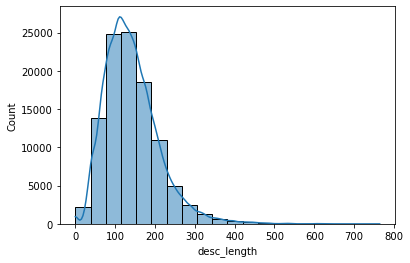

In [ ]:
def length(x):
  if type(x) == float:
    return 0 
  else:
    return len(x)

articles['desc_length'] = articles['detail_desc'].apply(length)
sns.histplot(articles, x='desc_length', bins=20, kde=True)

In [ ]:
articles.columns

Index(['product_code', 'prod_name', 'product_type_no', 'product_type_name',
       'product_group_name', 'graphical_appearance_no',
       'graphical_appearance_name', 'colour_group_code', 'colour_group_name',
       'perceived_colour_value_id', 'perceived_colour_value_name',
       'perceived_colour_master_id', 'perceived_colour_master_name',
       'department_no', 'department_name', 'index_code', 'index_name',
       'index_group_no', 'index_group_name', 'section_no', 'section_name',
       'garment_group_no', 'garment_group_name', 'detail_desc', 'desc_length'],
      dtype='object')

In [ ]:
#Extract natural language columns
articles_nlp = articles[['prod_name','product_type_name','product_group_name','graphical_appearance_name','colour_group_name','perceived_colour_value_name','perceived_colour_master_name','department_name','index_name','index_group_name','section_name','garment_group_name', 'detail_desc']]

In [ ]:
articles_nlp.head()

,prod_name,product_type_name,product_group_name,graphical_appearance_name,colour_group_name,perceived_colour_value_name,perceived_colour_master_name,department_name,index_name,index_group_name,section_name,garment_group_name,detail_desc
article_id,,,,,,,,,,,,,
108775015,Strap top,Vest top,Garment Upper body,Solid,Black,Dark,Black,Jersey Basic,Ladieswear,Ladieswear,Womens Everyday Basics,Jersey Basic,Jersey top with narrow shoulder straps.
108775044,Strap top,Vest top,Garment Upper body,Solid,White,Light,White,Jersey Basic,Ladieswear,Ladieswear,Womens Everyday Basics,Jersey Basic,Jersey top with narrow shoulder straps.
108775051,Strap top (1),Vest top,Garment Upper body,Stripe,Off White,Dusty Light,White,Jersey Basic,Ladieswear,Ladieswear,Womens Everyday Basics,Jersey Basic,Jersey top with narrow shoulder straps.
110065001,OP T-shirt (Idro),Bra,Underwear,Solid,Black,Dark,Black,Clean Lingerie,Lingeries/Tights,Ladieswear,Womens Lingerie,"Under-, Nightwear","Microfibre T-shirt bra with underwired, moulde..."
110065002,OP T-shirt (Idro),Bra,Underwear,Solid,White,Light,White,Clean Lingerie,Lingeries/Tights,Ladieswear,Womens Lingerie,"Under-, Nightwear","Microfibre T-shirt bra with underwired, moulde..."


In [ ]:
articles['product_type_name'].unique()
#Maybe filter out non-clothing? Like stain remover spray?

array(['Vest top', 'Bra', 'Underwear Tights', 'Socks', 'Leggings/Tights',
       'Sweater', 'Top', 'Trousers', 'Hair clip', 'Umbrella',
       'Pyjama jumpsuit/playsuit', 'Bodysuit', 'Hair string', 'Unknown',
       'Hoodie', 'Sleep Bag', 'Hair/alice band', 'Belt', 'Boots',
       'Bikini top', 'Swimwear bottom', 'Underwear bottom', 'Swimsuit',
       'Skirt', 'T-shirt', 'Dress', 'Hat/beanie', 'Kids Underwear top',
       'Shorts', 'Shirt', 'Cap/peaked', 'Pyjama set', 'Sneakers',
       'Sunglasses', 'Cardigan', 'Gloves', 'Earring', 'Bag', 'Blazer',
       'Other shoe', 'Jumpsuit/Playsuit', 'Sandals', 'Jacket', 'Costumes',
       'Robe', 'Scarf', 'Coat', 'Other accessories', 'Polo shirt',
       'Slippers', 'Night gown', 'Alice band', 'Straw hat', 'Hat/brim',
       'Tailored Waistcoat', 'Necklace', 'Ballerinas', 'Tie',
       'Pyjama bottom', 'Felt hat', 'Bracelet', 'Blouse',
       'Outdoor overall', 'Watch', 'Underwear body', 'Beanie', 'Giftbox',
       'Sleeping sack', 'Dungarees',

In [ ]:
articles_nlp[articles_nlp['product_type_name']=='Unknown']

,prod_name,product_type_name,product_group_name,graphical_appearance_name,colour_group_name,perceived_colour_value_name,perceived_colour_master_name,department_name,index_name,index_group_name,section_name,garment_group_name,detail_desc
article_id,,,,,,,,,,,,,
156224002,Box 4p Socks,Unknown,Unknown,Solid,Black,Dark,Black,Tights basic,Lingeries/Tights,Ladieswear,"Womens Nightwear, Socks & Tigh",Socks and Tights,Semi-matte socks with a short shaft. 20 denier.
473954008,OP Cheeky hipster 2p,Unknown,Unknown,Solid,Black,Dark,Black,Clean Lingerie,Lingeries/Tights,Ladieswear,Womens Lingerie,"Under-, Nightwear","Microfibre hipster briefs with a low waist, li..."
473954013,OP Cheeky hipster 2p,Unknown,Unknown,Solid,Light Beige,Dusty Light,Beige,Clean Lingerie,Lingeries/Tights,Ladieswear,Womens Lingerie,"Under-, Nightwear","Microfibre hipster briefs with a low waist, li..."
473954014,OP Cheeky hipster 2p,Unknown,Unknown,Solid,Yellowish Brown,Medium Dusty,Brown,Clean Lingerie,Lingeries/Tights,Ladieswear,Womens Lingerie,"Under-, Nightwear","Microfibre hipster briefs with a low waist, li..."
473954015,OP Cheeky hipster 2p,Unknown,Unknown,Solid,Yellowish Brown,Dark,Brown,Clean Lingerie,Lingeries/Tights,Ladieswear,Womens Lingerie,"Under-, Nightwear","Microfibre hipster briefs with a low waist, li..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
925139001,Ruben set,Unknown,Unknown,Solid,Black,Dark,Black,Other items,Ladies Accessories,Ladieswear,Womens Small accessories,Accessories,Set with a matching iPhone case and protective...
925139002,Ruben set,Unknown,Unknown,Solid,Light Pink,Dusty Light,Pink,Other items,Ladies Accessories,Ladieswear,Womens Small accessories,Accessories,Set with a matching iPhone case and protective...
925139003,Ruben set,Unknown,Unknown,Solid,Light Purple,Dusty Light,Lilac Purple,Other items,Ladies Accessories,Ladieswear,Womens Small accessories,Accessories,Set with a matching iPhone case and protective...


In [ ]:
articles['graphical_appearance_name'].unique()

array(['Solid', 'Stripe', 'All over pattern', 'Melange', 'Transparent',
       'Metallic', 'Application/3D', 'Denim', 'Colour blocking', 'Dot',
       'Other structure', 'Contrast', 'Treatment', 'Check', 'Chambray',
       'Front print', 'Glittering/Metallic', 'Mixed solid/pattern',
       'Placement print', 'Other pattern', 'Neps', 'Embroidery', 'Lace',
       'Jacquard', 'Unknown', 'Argyle', 'Slub', 'Mesh', 'Sequin',
       'Hologram'], dtype=object)

In [ ]:
articles['colour_group_name'].unique()

array(['Black', 'White', 'Off White', 'Light Beige', 'Beige', 'Grey',
       'Light Blue', 'Light Grey', 'Dark Blue', 'Dark Grey', 'Pink',
       'Dark Red', 'Greyish Beige', 'Light Orange', 'Silver', 'Gold',
       'Light Pink', 'Dark Pink', 'Yellowish Brown', 'Blue',
       'Light Turquoise', 'Yellow', 'Greenish Khaki', 'Dark Yellow',
       'Other Pink', 'Dark Purple', 'Red', 'Transparent', 'Dark Green',
       'Other Red', 'Turquoise', 'Dark Orange', 'Other', 'Orange',
       'Dark Beige', 'Other Yellow', 'Light Green', 'Other Orange',
       'Purple', 'Light Red', 'Light Yellow', 'Green', 'Light Purple',
       'Dark Turquoise', 'Other Purple', 'Bronze/Copper',
       'Other Turquoise', 'Other Green', 'Other Blue', 'Unknown'],
      dtype=object)

In [ ]:
articles['perceived_colour_value_name'].unique()

array(['Dark', 'Light', 'Dusty Light', 'Medium Dusty', 'Bright', 'Medium',
       'Undefined', 'Unknown'], dtype=object)

In [ ]:
articles['index_name'].unique()

array(['Ladieswear', 'Lingeries/Tights', 'Baby Sizes 50-98', 'Menswear',
       'Ladies Accessories', 'Sport', 'Children Sizes 92-140', 'Divided',
       'Children Sizes 134-170', 'Children Accessories, Swimwear'],
      dtype=object)

In [ ]:
articles['index_group_name'].unique()

array(['Ladieswear', 'Baby/Children', 'Menswear', 'Sport', 'Divided'],
      dtype=object)

In [ ]:
articles['section_name'].unique()

array(['Womens Everyday Basics', 'Womens Lingerie',
       'Womens Nightwear, Socks & Tigh', 'Baby Essentials & Complements',
       'Men Underwear', 'Mama', 'Womens Small accessories',
       'Men H&M Sport', 'Kids Boy', 'Divided Basics',
       'Girls Underwear & Basics', 'Mens Outerwear',
       'Womens Big accessories', 'Divided Accessories',
       'Womens Swimwear, beachwear', 'Divided Selected',
       'Boys Underwear & Basics', 'Contemporary Street',
       'Contemporary Casual', 'Men Accessories', 'Men Suits & Tailoring',
       'Womens Everyday Collection', 'Men Shoes', 'Young Boy', 'H&M+',
       'Divided Collection', 'Ladies Denim', 'Contemporary Smart',
       'Womens Trend', 'Kids Outerwear', 'Young Girl', 'Womens Shoes',
       'Womens Tailoring', 'Divided Projects', 'Denim Men', 'Men Other',
       'Womens Jackets', 'Men Other 2', 'Baby Boy', 'Womens Casual',
       'Kids Accessories, Swimwear & D', 'Ladies H&M Sport',
       'Kids & Baby Shoes', 'Baby Girl', 'Kids Girl

In [ ]:
articles['garment_group_name'].unique()

array(['Jersey Basic', 'Under-, Nightwear', 'Socks and Tights',
       'Jersey Fancy', 'Accessories', 'Trousers Denim', 'Outdoor',
       'Shoes', 'Swimwear', 'Knitwear', 'Shirts', 'Trousers', 'Dressed',
       'Shorts', 'Dresses Ladies', 'Skirts', 'Special Offers', 'Blouses',
       'Unknown', 'Woven/Jersey/Knitted mix Baby', 'Dresses/Skirts girls'],
      dtype=object)

In [ ]:
index_group_to_nlp = {'Ladieswear':"women", 'Baby/Children':'children', 'Menswear':'men', 'Sport':'sport', 'Divided':'all genders'}

In [ ]:
articles_nlp['index_group_name']=articles_nlp['index_group_name'].apply(lambda x: index_group_to_nlp[x])

/tmp/ipykernel_3715/807493271.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  articles_nlp['index_group_name']=articles_nlp['index_group_name'].apply(lambda x: index_group_to_nlp[x])


In [ ]:
desc_format = "A picture of a {0}, a {12} It is a {1}, which is a {2} for {9}. It is {6} with a {5} pattern."
articles_nlp['long_description'] = [desc_format.format(*r) for r in articles_nlp.values.tolist()]

/tmp/ipykernel_3715/2066214918.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  articles_nlp['long_description'] = [desc_format.format(*r) for r in articles_nlp.values.tolist()]


In [ ]:
articles_nlp["long_description"][108775015]

'A picture of a Strap top, a Jersey top with narrow shoulder straps. It is a Vest top, which is a Garment Upper body for women. It is Black with a Dark pattern.'

In [ ]:
articles["long_description"] = articles_nlp["long_description"]

# Creating Custom Dataset Class and DataLoader Object


In [ ]:
# Helper functions for creating data loader object 
def find_classes(directory):
    """Find the class folders in a dataset structured as follows::

            directory/
            ├── class_x
            │   ├── xxx.ext
            │   ├── xxy.ext
            │   └── ...
            │       └── xxz.ext
            └── class_y
                ├── 123.ext
                ├── nsdf3.ext
                └── ...
                └── asd932_.ext

        This method can be overridden to only consider
        a subset of classes, or to adapt to a different dataset directory structure.

        Args:
            directory(str): Root directory path, corresponding to ``self.root``

        Raises:
            FileNotFoundError: If ``dir`` has no class folders.

        Returns:
            (Tuple[List[str], Dict[str, int]]): List of all classes and dictionary mapping each class to an index.
        """
    directory = os.path.expanduser(directory)
    classes = sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())
    if not classes:
        raise FileNotFoundError(f"Couldn't find any class folder in {directory}.")

    class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}
    return classes, class_to_idx

def make_dataset(directory):
  # loads articles dataframe to get image descriptions from 
  articles = pd.read_csv(Config.base + 'articles.csv')

  # sets the primary index as the article id for optimized speed gains 
  articles = articles.set_index(['article_id'])
  extensions = ['.jpg', '.jpeg', '.png', '.ppm', '.bmp', '.pgm', '.tif', '.tiff', '.webp']
  images, captions = [], []
  _, class_to_idx = find_classes(directory)

  for target_class in sorted(class_to_idx.keys()):
      # class idx is supposed to be the class but we will redo this later 
      class_index = class_to_idx[target_class]
      target_dir = os.path.join(directory, target_class)
      if not os.path.isdir(target_dir):
          continue
      for root, _, fnames in sorted(os.walk(target_dir, followlinks=True)):
          for fname in sorted(fnames):
              # get image path
              path = os.path.join(root, fname)

              # get text article id
              article_id = fname.split('.')[0]
              description = articles.loc[articles.index == int(article_id), 'long_description'].values[0]

              # only add data if there exists a description i.e not empty
              if type(description) == str:
                captions.append(description)
                images.append(path)

  return images, captions 

# Resizes the data and Normalizes the data
def get_transforms(train=True):

  # Can potentially change the transformation function given training/validation data 
  if train:
        return alb.Compose(
            [
                alb.Resize(Config.image_size, Config.image_size, always_apply=True),
                alb.Normalize(max_pixel_value=255.0, always_apply=True),
            ]
        )
  else:
        return alb.Compose(
            [
                alb.Resize(Config.image_size, Config.image_size, always_apply=True),
                alb.Normalize(max_pixel_value=255.0, always_apply=True),
            ]
        )

In [ ]:
class HMDataset(torch.utils.data.Dataset):
  def __init__(self, root, tokenizer, transforms):
    """
    There is a one to one correspondance between images and text.
    """
    self.images, self.captions = make_dataset(root)

    # tokenize the captions 
    self.encoded_captions = tokenizer(
            list(self.captions), padding=True, truncation=True, max_length=Config.max_length
        ) 

    self.transforms = transforms 

  def __getitem__(self, index):
    item = {
            key: torch.tensor(values[index])
            for key, values in self.encoded_captions.items()
        }

    image = self.images[index]
    image = cv2.imread(image)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
      
    image = self.transforms(image=image)['image']
    item['image'] = torch.tensor(image).permute(2, 0, 1).float()
    item['caption'] = self.captions[index]

    return item 

  def __len__(self):
    return len(self.images)

In [ ]:
tokenizer = DistilBertTokenizer.from_pretrained(Config.text_tokenizer)
transforms = get_transforms()
dataset = HMDataset(
        Config.base + 'images/',
        tokenizer=tokenizer,
        transforms=transforms
    )

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


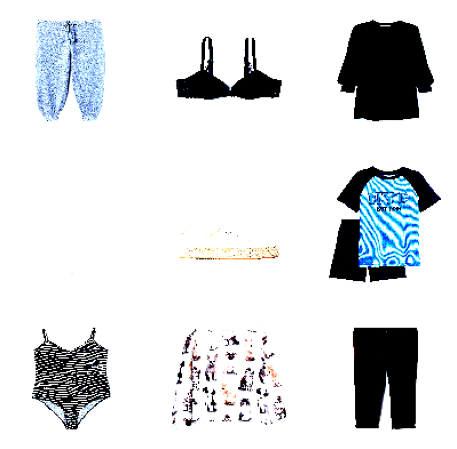

In [ ]:
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(dataset), size=(1,)).item()
    img = dataset[sample_idx]['image']
    figure.add_subplot(rows, cols, i)
    plt.axis("off")
    plt.imshow(img.squeeze().permute(1, 2, 0))
plt.show()

# Baseline Deep Model - Alexander

# Creating CLIP Model

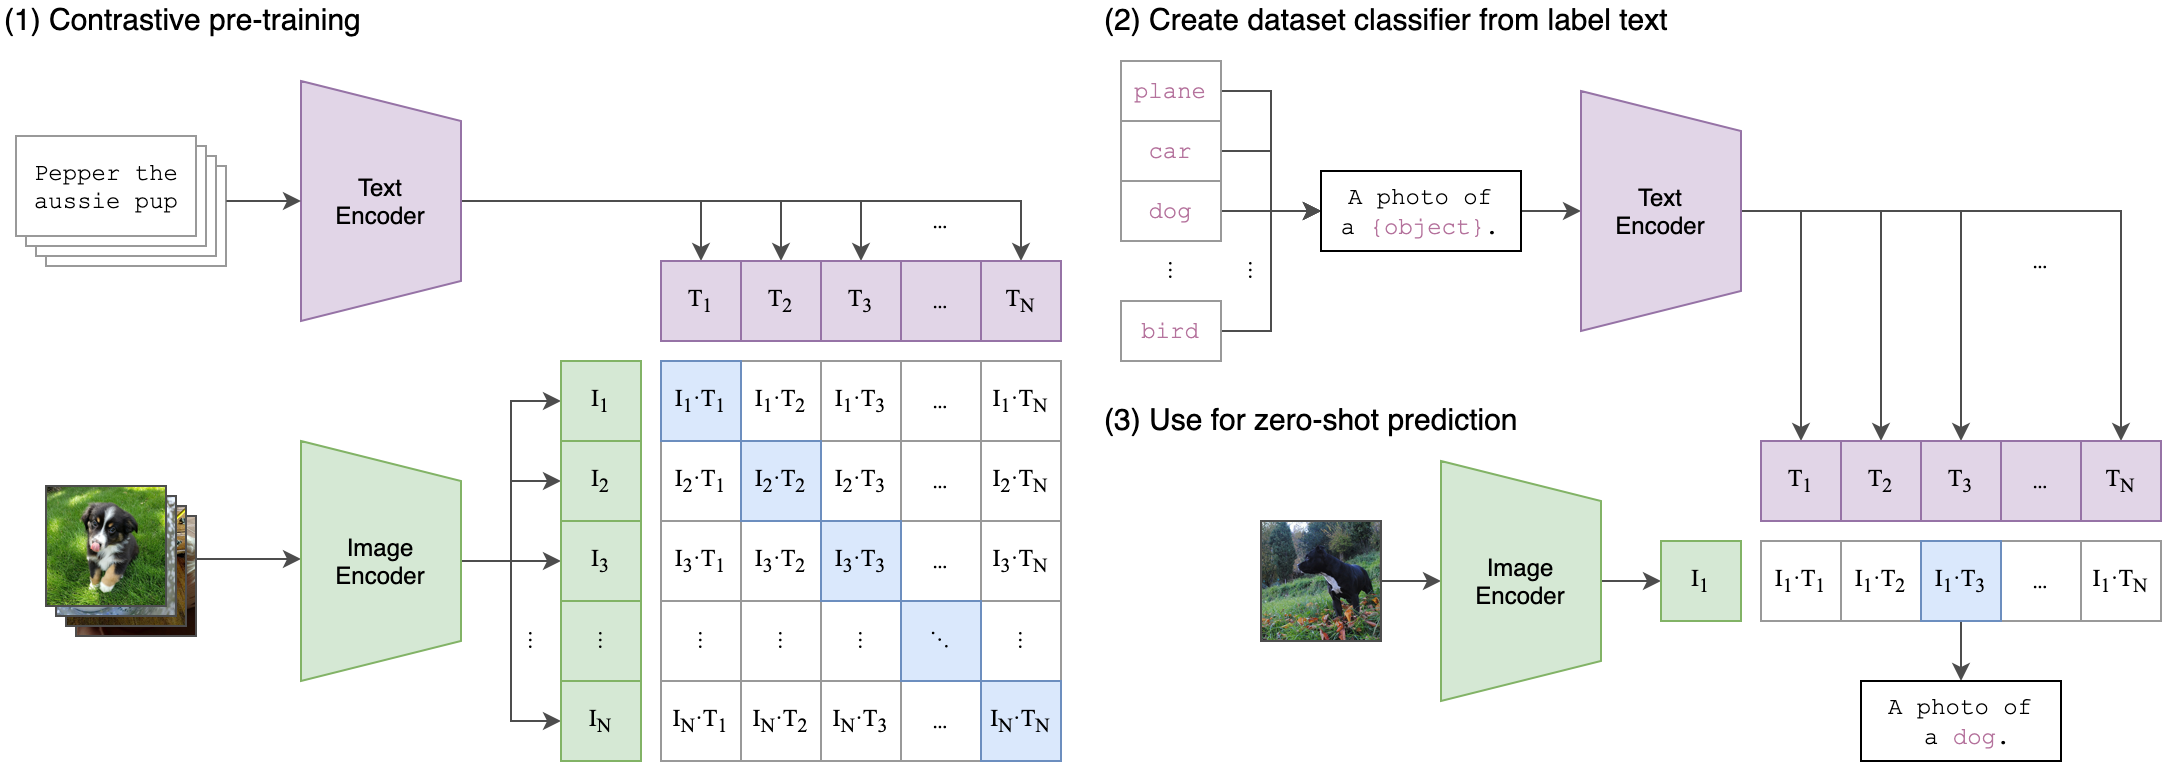

The following code was based on a simpler implementation of [OpenAI CLIP](https://openai.com/blog/clip/). Most notably, we are under some serious 
computational constrants so a lot of the design decisions were centered around 
maintaining performance while keeping training and inference times low. We will
go into more detail below on the design decisionss and the differences between 
our implementation and the original paper. 

Generally the CLIP model consists mostly of the following:
*     Text Encoder
*     Image Encoder 
*     Projection Head 
*     Contrastive Loss



In [ ]:
'''
    The code encodes each image to a fixed size vector with the size of the model’s output channels
    (2048 for resnet). This is the output after the pooling layer. 

    Resnet50 was chosen because it is the most accurate model while still remaining
    relatively lightweight and therefore is a good choice for our image encoder.
'''
# Todo: Play around with models + hyperparemeters
# maybe make it faster
class ImageEncoder(nn.Module):
  def __init__(self, model_name=Config.model_name, pretrained=Config.pretrained, trainable=Config.trainable):
    super().__init__()
    '''
    `timm` is a deep-learning library created by Ross Wightman and is a collection of SOTA computer vision models,
     layers, utilities, optimizers, schedulers, data-loaders, augmentations and also training/validating scripts
     with ability to reproduce ImageNet training results.
    '''
    self.model = timm.create_model(model_name, pretrained, num_classes=0, global_pool='avg')

    # whether to allow weights to change
    for p in self.model.parameters():
      p.requires_grad = trainable
    
  def forward(self, x):
    return self.model(x)

In [ ]:
'''
    The code encodes each text span to a fixed size vector with the size of the model’s output channels
    (768 for DistillBert). This is the output after the pooling layer. 

    DistillBert was chosen because it performs almost as well as Bert while remaining
    much faster than Bert. Ideally Bert or RoBerta would have been used here instead,
    however because we are limited by our computational power, DistillBert is the best choice
'''

# Todo: Play around with models + hyperparemeters
# maybe make it faster
class TextEncoder(nn.Module):
  def __init__(self, model_name=Config.text_encoder_model, pretrained=Config.pretrained, trainable=Config.trainable):
    super().__init__()
    if pretrained:
      self.model = DistilBertModel.from_pretrained(model_name)
    else:
      self.model = DistilBertModel(config=DistilBertConfig())
    
    # whether to allow weights to change
    for p in self.model.parameters():
      p.requires_grad = trainable
    
    # use CLS token hidden representation as sentence embedding
    self.target_token = 0

  def forward(self, ids, mask):
    x = self.model(input_ids=ids, attention_mask=mask)
    last = x.last_hidden_state

    # DistilBert output hidden representation is veector of size 768
    return last[:, self.target_token, :]

In [ ]:
# Projection head serves to associate
# text and image vectors into the projection dimmension for comparison

class ProjectionHead(nn.Module):
  def __init__(self, embed_dim, project_dim=Config.projection_dim, dropout=Config.dropout):
    # embed dim is size of input vector 
    # Images are vectors of size 2048
    # Text is vectors of size 768 
    # Project dim is size of output vector (256)
    super().__init__()

    self.projection = nn.Linear(embed_dim, project_dim)

    # according to CLIP paper GELU performs better than ReLU
    self.activation = nn.GELU()

    self.fc = nn.Linear(project_dim, project_dim)

    # Use dropout to prevent overfitting
    self.dropout = nn.Dropout(dropout)

    # layernorm is preferred to batchnorm in NLP applications
    self.layer_norm = nn.LayerNorm(project_dim)
  
  def forward(self, x):
    projected = self.projection(x)
    x = self.activation(projected)
    x = self.fc(x)
    x = self.dropout(x)
    # introduce skip connection for faster training through backpropogation
    x = x + projected
    x = self.layer_norm(x)

    return x


In [ ]:
def contrastive_loss(text_embedding, image_embedding):
  # logit = torch.dot(text_embedding, image_embedding) / Config.temperature
  logit = (text_embedding @ image_embedding.T) / Config.temperature
  text_similarity = text_embedding @ text_embedding.T
  image_similarity = image_embedding @ image_embedding.T

  # get targets by averaging text and image similarity
  targets = F.softmax(
      (image_similarity + text_similarity) / 2 * Config.temperature,
      dim = 1
  )

  text_loss = cross_entropy(logit, targets)
  image_loss = cross_entropy(logit.T, targets.T)

  avg_loss = (text_loss + image_loss) / 2.0
  return avg_loss.mean()


def cross_entropy(pred, labels, reduction='none'):
  '''
  Define custom function since there is a potential for multiple captions per image
  '''

  log_softmax = nn.LogSoftmax(dim=-1)
  loss = (-labels * log_softmax(pred)).sum(1)

  if reduction == 'mean':
    loss = loss.mean()
  
  return loss 


In [ ]:
class CLIP(nn.Module):
  def __init__(self, image_dim=Config.image_embedding, text_dim=Config.text_embedding):
    super().__init__()
    self.image_encoder = ImageEncoder()
    self.text_encoder = TextEncoder()
    self.image_projection = ProjectionHead(embed_dim=image_dim)
    self.text_projection = ProjectionHead(embed_dim=text_dim)

    # initialize both image and text projections using xavier 
    self.image_projection.apply(initialize_weights)
    self.text_projection.apply(initialize_weights)

  def forward(self, batch):
    # encode the image
    image_features = self.image_encoder(batch['image'])

    # encode the text
    text_features = self.text_encoder(
        ids=batch['input_ids'],
        mask=batch['attention_mask'])
    
    image_embeddings = self.image_projection(image_features)
    text_embeddings = self.text_projection(text_features)

    #calculate loss
    return contrastive_loss(image_embeddings, text_embeddings)

def initialize_weights(m):
  if isinstance(m, nn.Linear):
      nn.init.kaiming_uniform_(m.weight.data)
      nn.init.constant_(m.bias.data, 0)

# Training CLIP Model

*   Defining Metric Class
*   Defining Traning Code
*   Defining Validation Code 
*   Putting it all together and Executing



In [ ]:
class AvgMeter:
    def __init__(self, name="Metric"):
        self.name = name

        # reinitalizes the avg, sum, and count
        self.reset()

    def reset(self):
        self.avg, self.sum, self.count = [0] * 3

    # updates the weight based on a new value, count pair
    def update(self, val, count=1):
        self.count += count
        self.sum += val * count
        self.avg = self.sum / self.count

    # textual representation of the class 
    def __repr__(self):
        text = f"{self.name}: {self.avg:.4f}"
        return text
    
    # float representation fo the class
    def get_loss(self):
      return self.avg

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group["lr"]

In [ ]:
def train_epoch(model, train_loader, optimizer):
    loss_meter = AvgMeter()
    tqdm_object = tqdm(train_loader, total=len(train_loader))
    i = 0
    for batch in tqdm_object:
      i += 1
      batch = {k: v.to(Config.device) for k, v in batch.items() if k != "caption"}
      loss = model(batch)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      
      count = batch["image"].size(0)
      loss_meter.update(loss.item(), count)
      tqdm_object.set_postfix(train_loss=loss_meter.avg, lr=get_lr(optimizer))

    return loss_meter

def valid_epoch(model, valid_loader):
    loss_meter = AvgMeter()

    tqdm_object = tqdm(valid_loader, total=len(valid_loader))
    for batch in tqdm_object:
        batch = {k: v.to(Config.device) for k, v in batch.items() if k != "caption"}
        loss = model(batch)

        count = batch["image"].size(0)
        loss_meter.update(loss.item(), count)

        tqdm_object.set_postfix(valid_loss=loss_meter.avg)
    return loss_meter

In [ ]:
train_size = int(0.8 * len(dataset))
valid_size = len(dataset) - train_size

# split full dataset into a training/test set with an 80/20 split
train_dataset, valid_dataset = torch.utils.data.random_split(
    dataset, [train_size, valid_size]
    )

indices = torch.randperm(len(train_dataset))
train_loader = torch.utils.data.DataLoader(
    torch.utils.data.Subset(train_dataset, indices),
    batch_size=Config.batch_size,
    num_workers=Config.num_workers,
)

indices = torch.randperm(len(valid_dataset))
valid_loader = torch.utils.data.DataLoader(
    torch.utils.data.Subset(valid_dataset, indices),
    batch_size=Config.batch_size,
    num_workers=Config.num_workers,
)

model = CLIP().to(Config.device)
params = [
        {"params": model.image_encoder.parameters(), "lr": Config.image_encoder_lr},
        {"params": model.text_encoder.parameters(), "lr": Config.text_encoder_lr},
        {"params": itertools.chain(
            model.image_projection.parameters(), model.text_projection.parameters()
        ), "lr": Config.head_lr, "weight_decay": Config.weight_decay}
    ]

optimizer = torch.optim.AdamW(params)
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode="min", patience=Config.patience, factor=Config.factor
    )

# Todo cosine schedule optimizer

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_projector.weight', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
def train_model():
  step = 'batch'
  model = CLIP().to(Config.device)
  params = [
        {"params": model.image_encoder.parameters(), "lr": Config.image_encoder_lr},
        {"params": model.text_encoder.parameters(), "lr": Config.text_encoder_lr},
        {"params": itertools.chain(
            model.image_projection.parameters(), model.text_projection.parameters()
        ), "lr": Config.head_lr, "weight_decay": Config.weight_decay}
    ]

  optimizer = torch.optim.AdamW(params)
  lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode="min", patience=Config.patience, factor=Config.factor
    )

  train_losses = np.array([])
  valid_losses = np.array([])
  min_loss = float('inf')

  for epoch in range(Config.epochs):
    print(f"Epoch: {epoch + 1} \n")
    model.train()
    train_loss = train_epoch(model, train_loader, optimizer)
    print(f"Train Loss: {train_loss}")
    np.append(train_losses, train_loss.get_loss())

    model.eval()
    with torch.no_grad():
      valid_loss = valid_epoch(model, valid_loader)
      np.append(valid_losses, valid_loss.get_loss())

      if valid_loss.get_loss() < min_loss:
        torch.save(model.state_dict(), "best.pt")
        min_loss = valid_loss.get_loss()
    
    lr_scheduler.step(valid_loss.get_loss())
    print(f"Valid Loss: {valid_loss}")
    savetxt('train_losses.csv', train_losses, delimiter=',')
    savetxt('valid_losses.csv', valid_losses, delimiter=',')
  
  return train_losses, valid_losses 
  
train_losses, valid_losses = train_model()

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_projector.weight', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch: 1 



  0%|          | 0/655 [00:00<?, ?it/s]

Train Loss: Metric: 4.5923


  0%|          | 0/164 [00:00<?, ?it/s]

Valid Loss: Metric: 2.7936
Epoch: 2 



  0%|          | 0/655 [00:00<?, ?it/s]

Train Loss: Metric: 2.2747


  0%|          | 0/164 [00:00<?, ?it/s]

Valid Loss: Metric: 1.7374
Epoch: 3 



  0%|          | 0/655 [00:00<?, ?it/s]

Train Loss: Metric: 1.4828


  0%|          | 0/164 [00:00<?, ?it/s]

Valid Loss: Metric: 1.3562
Epoch: 4 



  0%|          | 0/655 [00:00<?, ?it/s]

Train Loss: Metric: 1.0520


  0%|          | 0/164 [00:00<?, ?it/s]

Valid Loss: Metric: 1.2143
Epoch: 5 



  0%|          | 0/655 [00:00<?, ?it/s]

Train Loss: Metric: 0.7655


  0%|          | 0/164 [00:00<?, ?it/s]

Valid Loss: Metric: 1.2147
Epoch: 6 



  0%|          | 0/655 [00:00<?, ?it/s]

Train Loss: Metric: 0.5519


  0%|          | 0/164 [00:00<?, ?it/s]

Valid Loss: Metric: 1.2717
Epoch: 7 



  0%|          | 0/655 [00:00<?, ?it/s]

Train Loss: Metric: 0.3666


  0%|          | 0/164 [00:00<?, ?it/s]

Valid Loss: Metric: 1.3121
Epoch: 8 



  0%|          | 0/655 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

In [ ]:
def plot_train_val(x, train, train_label, val=None, val_label=None, title=None):
  plt.plot(x, train, label=train_label)

  if val and val_label:
    plt.plot(x, val, label=val_label)
  plt.legend(loc='lower right')

  plt.xlabel('epoch')
  plt.ylabel('Contrastive Loss')
  plt.title(title)
  plt.show()

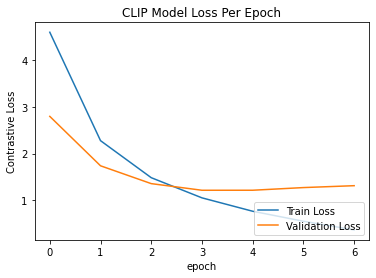

In [ ]:
# had to hard code model train/valid loss in case data was lost (it was in fact lost) since it takes so long to train
train_losses = [4.5923, 2.2747, 1.4828, 1.0520, 0.7655, 0.5519, 0.3666]
valid_losses = [2.7936, 1.7374, 1.3562, 1.2143, 1.2147, 1.2717, 1.3121]
x = np.arange(0, len(train_losses))
plot_train_val(x,
               train_losses,
               train_label='Train Loss',
               val=valid_losses, 
               val_label='Validation Loss',
               title='CLIP Model Loss Per Epoch')

# Making Predictions with Custom CLIP


*   Creating Image Embeddings using Trained Model
*   Using Contrastive Loss to map image embeddings to query
*   Evaluation Analysis






In [ ]:
def get_image_embeddings(data, model):
  embeddings = []

  model.eval()

  # makes model weights non trainable
  with torch.no_grad():
    for batch in tqdm(data):
      # encode + project images 
      image_features = model.image_encoder(batch["image"].to(Config.device))
      image_embeddings = model.image_projection(image_features)
      embeddings.append(image_embeddings)
  
  return torch.cat(embeddings)

In [ ]:
def find_matches(model, image_embeddings, image_filenames, query, n=9):

  # tokenize query 
    tokenizer = DistilBertTokenizer.from_pretrained(Config.text_tokenizer)
    encoded_query = tokenizer([query])
    batch = {
        key: torch.tensor(values).to(Config.device)
        for key, values in encoded_query.items()
    }
    with torch.no_grad():

      # get text features + projection 
        text_features = model.text_encoder(
            ids=batch["input_ids"], mask=batch["attention_mask"]
        )
        text_embeddings = model.text_projection(text_features)
    
    # use contrastive loss to find closest matches 
    image_embeddings_n = F.normalize(image_embeddings, p=2, dim=-1)
    text_embeddings_n = F.normalize(text_embeddings, p=2, dim=-1)
    dot_similarity = text_embeddings_n @ image_embeddings_n.T
    
    values, indices = torch.topk(dot_similarity.squeeze(0), n)
    matches = [image_filenames[idx] for idx in indices]
    
    # _, axes = plt.subplots(3, 3, figsize=(10, 10))
    i = 1
    # for match, ax in zip(matches, axes.flatten()):
    #     image = cv2.imread(match)
    #     image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    #     ax.imshow(image)
    #     ax.axis("off")
    #     ax.set_title(f'Match: {i}')
    #     i += 1
    
    image = cv2.imread(matches[0])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image)
    plt.axis("off")
    plt.title(f'Match: {i}')
    
    plt.show()

In [ ]:
import gc
gc.collect()
torch.cuda.empty_cache()

In [ ]:
model = model = CLIP().to(Config.device)
model.load_state_dict(torch.load('best.pt'))
model.eval()
image_embeddings = get_image_embeddings(valid_loader, model)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_projector.weight', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/164 [00:00<?, ?it/s]

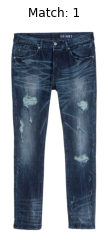

In [ ]:
find_matches(model,
             image_embeddings,
             image_filenames=valid_dataset.dataset.images,
             query='Blue jeans with rips',
             n=1)

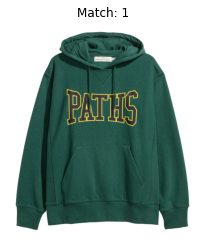

In [ ]:
find_matches(model,
             image_embeddings,
             image_filenames=valid_dataset.dataset.images,
             query='Green Hoodie with letters on front',
             n=1)

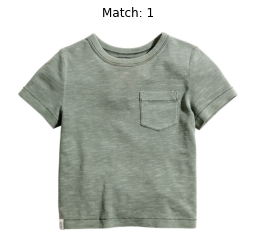

In [ ]:
find_matches(model,
             image_embeddings,
             image_filenames=valid_dataset.dataset.images,
             query='Short, green t-shirt with front pocket',
             n=1)

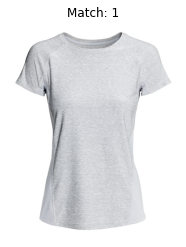

In [ ]:
find_matches(model,
             image_embeddings,
             image_filenames=valid_dataset.dataset.images,
             query='Short sleeved, white shirt',
             n=1)

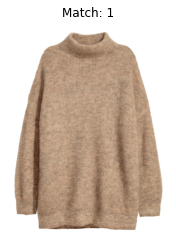

In [ ]:
find_matches(model,
             image_embeddings,
             image_filenames=valid_dataset.dataset.images,
             query='Long, brown, Fleece turtleneck',
             n=1)

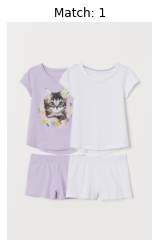

In [ ]:
find_matches(model,
             image_embeddings,
             image_filenames=valid_dataset.dataset.images,
             query='Childrens matching pajamas',
             n=1)

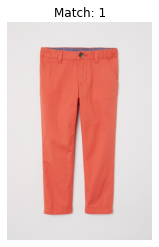

In [ ]:
find_matches(model,
             image_embeddings,
             image_filenames=valid_dataset.dataset.images,
             query='Long Orange chino pants',
             n=1)

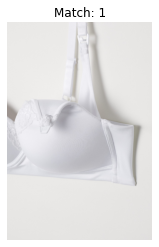

In [ ]:
find_matches(model,
             image_embeddings,
             image_filenames=valid_dataset.dataset.images,
             query='White bra',
             n=1)

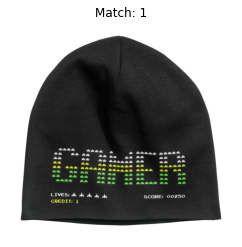

In [ ]:
find_matches(model,
             image_embeddings,
             image_filenames=valid_dataset.dataset.images,
             query='Black beanie with no text',
             n=1)